In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 128.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [6]:
TRAINED_MODEL_NAME = "Hiver77/MDT"
# TRAINED_MODEL_NAME = "tomkat-cr/abstractgo-v1.1"

BASE_MODEL_NAME = "dmis-lab/biobert-v1.1"

In [7]:
from datasets import Dataset
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType


In [8]:
import pandas as pd

In [10]:
df_challenge = pd.read_csv('/content/challenge_data.csv', on_bad_lines='skip', sep=';')

In [ ]:
df_challenge.head()

,title,abstract,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological


In [11]:
all_label_combinations = df_challenge['group'].unique()
print(all_label_combinations)

['neurological|hepatorenal' 'neurological' 'hepatorenal' 'cardiovascular'
 'neurological|oncological' 'cardiovascular|hepatorenal' 'oncological'
 'neurological|cardiovascular' 'cardiovascular|oncological'
 'neurological|hepatorenal|oncological'
 'neurological|cardiovascular|hepatorenal' 'hepatorenal|oncological'
 'cardiovascular|hepatorenal|oncological'
 'neurological|cardiovascular|hepatorenal|oncological'
 'neurological|cardiovascular|oncological']


In [4]:
labels = ["neurological", "hepatorenal", "cardiovascular", "oncological"]

In [12]:
model_checkpoint = BASE_MODEL_NAME
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def encode_labels(label_str):
    onehot = [0] * len(labels)
    for lbl in label_str.split("|"):
        idx = labels.index(lbl)
        onehot[idx] = 1
    return onehot

df_challenge["labels"] = df_challenge["group"].apply(encode_labels)

# Crear Dataset de HuggingFace
dataset = Dataset.from_pandas(df_challenge)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
dataset

Dataset({
    features: ['title', 'abstract', 'group', 'labels'],
    num_rows: 3565
})

In [14]:
def tokenize(batch):
    batch["text"] = [title + " " + abstract for title, abstract in zip(batch["title"], batch["abstract"])]
    return tokenizer(batch["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3565 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    problem_type="multi_label_classification", # crucial para la pérdida y activación correctas
    num_labels=len(labels),
    id2label={i: label for i, label in enumerate(labels)},
    label2id={label: i for i, label in enumerate(labels)}
)

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
lora_config = LoraConfig(
    r=16, # Rango de las matrices de adaptación
    lora_alpha=32, # Factor de escala
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS # Especificar el tipo de tarea
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters() # Muestra la reducción de parámetros entrenables


trainable params: 592,900 || all params: 108,906,248 || trainable%: 0.5444


In [19]:
# 3. Definir Argumentos de Entrenamiento y el Trainer
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch", # Corrected parameter name
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

In [20]:
import torch # Import torch
from transformers import DataCollatorWithPadding

# Set the format to torch
tokenized_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

# Define a custom data collator to ensure labels are float32
class FloatLabelsDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        batch["labels"] = batch["labels"].to(torch.float32)
        return batch

data_collator = FloatLabelsDataCollator(tokenizer=tokenizer)

# Split the dataset into training and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
tokenized_train_dataset = train_test_split['train']
tokenized_val_dataset = train_test_split['test']

# Define a simple compute_metrics function (you might want to customize this)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


def compute_metrics_function(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid to predictions for multi-label classification
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    predictions = sigmoid(predictions)
    # Convert predictions to binary based on a threshold (e.g., 0.5)
    y_pred = np.where(predictions > 0.5, 1, 0)
    y_true = labels

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    # AUC is typically calculated for each label separately in multi-label classification
    # This is a simplified example and might need adjustment based on your needs
    try:
        auc_score = roc_auc_score(y_true, predictions, average='macro')
    except ValueError:
        auc_score = 0.0 # Handle cases where AUC cannot be calculated

    return {
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "roc_auc_macro": auc_score,
    }


# Now create the Trainer with the split datasets and the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_function,
    data_collator=data_collator, # Pass the custom data collator
)

/tmp/ipython-input-414335924.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


-------------------------------------
-------------------------------------

*** HASTA AQUI LA PARTE COMUN QUE SE DEBE EJECUTAR PARA TODAS LAS DEMAS SECCIONES EN CASO QUE SE DESCONECTE EL NOTEBOOK ***

-------------------------------------
-------------------------------------


In [ ]:
# 4. Iniciar el entrenamiento
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Roc Auc Macro
1,No log,0.437442,0.808555,0.644993,0.440746,0.838068
2,0.481600,0.364565,0.866059,0.766504,0.608783,0.899946
3,0.373500,0.319369,0.876928,0.789442,0.646201,0.918645
4,0.373500,0.290646,0.895863,0.826620,0.781663,0.930976
5,0.307000,0.274116,0.903576,0.840580,0.810978,0.938739
6,0.280500,0.263152,0.907784,0.849111,0.820921,0.943520
7,0.280500,0.254453,0.908485,0.850772,0.821507,0.946817
8,0.256000,0.249203,0.909888,0.853728,0.825382,0.947467
9,0.246500,0.246260,0.910238,0.854048,0.826009,0.949216
10,0.242300,0.244776,0.911641,0.856328,0.828123,0.949513


TrainOutput(global_step=3570, training_loss=0.3108566204038989, metrics={'train_runtime': 2216.9955, 'train_samples_per_second': 12.864, 'train_steps_per_second': 1.61, 'total_flos': 7840020701970432.0, 'train_loss': 0.3108566204038989, 'epoch': 10.0})


** GUARDAR EL MODELO LOCALMENTE ***


In [ ]:
# 4. IMPORTANTE: Guardar manualmente la configuración base
from transformers import AutoConfig # Import AutoConfig
config = AutoConfig.from_pretrained(model_checkpoint) # Load the config

config.save_pretrained("./results")
tokenizer.save_pretrained("./results")

# 5. Ahora ./results tendrá TODO lo necesario para el push
trainer.save_model("./results")

In [ ]:
from huggingface_hub import notebook_login


** PUBLICAR EL MODELO EN HUGGING FACE **


In [ ]:
notebook_login()

In [ ]:
from peft import PeftModel, AutoPeftModelForSequenceClassification

# Después del entrenamiento
# El modelo final está en ./results
trained_model = AutoPeftModelForSequenceClassification.from_pretrained("./results", torch_dtype="auto", num_labels=len(labels))

# Ahora sí puedes hacer push
trained_model.push_to_hub(TRAINED_MODEL_NAME)
tokenizer.push_to_hub(TRAINED_MODEL_NAME)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tomkat-cr/abstractgo-v1.1/commit/a4661326344435d1e8fdcb63fef4efbd363a8d75', commit_message='Upload tokenizer', commit_description='', oid='a4661326344435d1e8fdcb63fef4efbd363a8d75', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tomkat-cr/abstractgo-v1.1', endpoint='https://huggingface.co', repo_type='model', repo_id='tomkat-cr/abstractgo-v1.1'), pr_revision=None, pr_num=None)

In [ ]:
# Sube tu modelo a Hugging Face Hub
# model.push_to_hub(TRAINED_MODEL_NAME)
# tokenizer.push_to_hub(TRAINED_MODEL_NAME)

# Luego crea un Space en huggingface.co/spaces

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...pjrn4tveo/adapter_model.safetensors:  22%|##2       |  534kB / 2.38MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Hiver77/MDT/commit/91140b25c9a7c81e91fc4c2b4d36b12f660f346e', commit_message='Upload tokenizer', commit_description='', oid='91140b25c9a7c81e91fc4c2b4d36b12f660f346e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Hiver77/MDT', endpoint='https://huggingface.co', repo_type='model', repo_id='Hiver77/MDT'), pr_revision=None, pr_num=None)


** BATCH PROCESSING DE VARIOS TITLE+ABSTRACT **


In [ ]:
from transformers import AutoModelForSequenceClassification
hf_uploaded_model = AutoModelForSequenceClassification.from_pretrained(TRAINED_MODEL_NAME, torch_dtype="auto", num_labels=len(labels))

adapter_config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

In [ ]:
# Batch processing desde /content/test.csv | Definicion de Funciones

import pandas as pd
import torch
from typing import List, Dict, Union
import numpy as np
from tqdm import tqdm

def combinar_titulo_abstract(row):
    """
    Combina título y abstract en un solo texto para clasificación
    """
    title = str(row.get('title', '')).strip()
    abstract = str(row.get('abstract', '')).strip()

    # Manejar valores NaN o None
    if title.lower() in ['nan', 'none', '']:
        title = ''
    if abstract.lower() in ['nan', 'none', '']:
        abstract = ''

    # Combinar con separador especial
    if title and abstract:
        return f"{title} [SEP] {abstract}"
    elif title:
        return title
    elif abstract:
        return abstract
    else:
        return "No content available"

def clasificar_articulo_medico_batch(textos: List[str], top_k=3, batch_size=32):
    """
    Clasifica múltiples artículos médicos en lotes para mejor rendimiento
    """
    all_results = []

    # Procesar en lotes
    for i in tqdm(range(0, len(textos), batch_size), desc="Clasificando artículos"):
        batch_textos = textos[i:i+batch_size]

        # Tokenizar lote completo
        inputs = tokenizer(
            batch_textos,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Predicción del lote
        with torch.no_grad():
            outputs = hf_uploaded_model(**inputs)
            predictions = torch.sigmoid(outputs.logits)  # Para multi-label

        # Procesar cada predicción del lote
        batch_probabilities = predictions.cpu().numpy()

        for prob_array in batch_probabilities:
            # Crear lista de (label, probabilidad) para cada artículo
            results = []
            for j, prob in enumerate(prob_array):
                if hasattr(hf_uploaded_model, 'config') and hasattr(hf_uploaded_model.config, 'id2label'):
                    label = hf_uploaded_model.config.id2label[j]
                else:
                    label = labels[j]
                results.append((label, float(prob)))

            # Ordenar por probabilidad y tomar top_k
            results.sort(key=lambda x: x[1], reverse=True)
            all_results.append(results[:top_k])

    return all_results

In [ ]:
def clasificar_csv(archivo_csv: str, top_k=3, batch_size=32, output_file=None):
    """
    Clasifica artículos médicos desde un archivo CSV

    Args:
        archivo_csv: Ruta al archivo CSV
        top_k: Número de categorías top a retornar
        batch_size: Tamaño del lote para procesamiento
        output_file: Archivo donde guardar los resultados (opcional)

    Returns:
        DataFrame con las clasificaciones
    """
    print(f"Cargando datos desde {archivo_csv}...")
    df = pd.read_csv(archivo_csv, sep=';')

    # Verificar que existan las columnas requeridas
    required_columns = ['title', 'abstract']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        raise ValueError(f"Faltan las columnas: {missing_columns}. Columnas disponibles: {df.columns.tolist()}")

    print(f"Datos cargados: {len(df)} artículos encontrados")

    # Combinar título y abstract
    print("Combinando títulos y abstracts...")
    textos_combinados = df.apply(combinar_titulo_abstract, axis=1).tolist()

    # Clasificar todos los textos
    print("Iniciando clasificación...")
    clasificaciones = clasificar_articulo_medico_batch(textos_combinados, top_k, batch_size)

    # Crear DataFrame con resultados
    print("Procesando resultados...")
    resultados_expandidos = []

    for idx, clasificacion in enumerate(clasificaciones):
        row_base = {
            'index': idx,
            'title': df.iloc[idx]['title'],
            'abstract': df.iloc[idx]['abstract'],
            'texto_combinado': textos_combinados[idx][:200] + "..." if len(textos_combinados[idx]) > 200 else textos_combinados[idx]
        }

        # Agregar las top_k clasificaciones
        for rank, (label, prob) in enumerate(clasificacion, 1):
            row_base[f'top_{rank}_categoria'] = label
            row_base[f'top_{rank}_probabilidad'] = prob

        resultados_expandidos.append(row_base)

    df_resultados = pd.DataFrame(resultados_expandidos)

    # Guardar si se especifica archivo de salida
    if output_file:
        df_resultados.to_csv(output_file, index=False)
        print(f"Resultados guardados en: {output_file}")

    return df_resultados

In [ ]:
def mostrar_resultados(df_resultados, num_ejemplos=5):
    """
    Muestra los primeros resultados de manera legible
    """
    print(f"\n=== PRIMEROS {num_ejemplos} RESULTADOS ===")

    # Check and print the id2label mapping from the model if available
    if hasattr(hf_uploaded_model, 'config') and hasattr(hf_uploaded_model.config, 'id2label'):
        print("\nModel's id2label mapping:")
        print(hf_uploaded_model.config.id2label)
    else:
        print("\nModel does not have an id2label mapping in config. Using the 'labels' list.")
        print(f"Labels list: {labels}")


    for i in range(min(num_ejemplos, len(df_resultados))):
        row = df_resultados.iloc[i]
        print(f"\n--- Artículo {i+1} ---")
        print(f"Título: {row['title']}")
        print(f"Abstract: {str(row['abstract'])[:150]}...")
        print("Clasificaciones:")

        # Mostrar las top clasificaciones
        for j in range(1, 4):  # Asumiendo top_3
            categoria_col = f'top_{j}_categoria'
            prob_col = f'top_{j}_probabilidad'
            if categoria_col in row:
                predicted_label_key = row[categoria_col] # This will be like 'LABEL_0'
                try:
                    # Extract the index from the predicted_label_key (e.g., 'LABEL_0' -> 0)
                    label_index = int(predicted_label_key.split('_')[-1])
                    # Use the index to get the label name from the 'labels' list
                    if label_index < len(labels):
                        categoria = labels[label_index]
                    else:
                        categoria = predicted_label_key # Fallback if index is out of bounds
                except (ValueError, IndexError):
                    categoria = predicted_label_key # Fallback if key format is unexpected

                prob = row[prob_col]
                print(f"  {j}. {categoria}: {prob:.4f} ({prob*100:.1f}%)")

In [ ]:
# Batch processing desde /content/test.csv | Ejecucion

df_resultados = clasificar_csv(
    archivo_csv='/content/test.csv',
    top_k=3,
    batch_size=32,
    output_file='clasificaciones_resultados.csv'
)

mostrar_resultados(df_resultados)

Cargando datos desde /content/test.csv...
Datos cargados: 9 artículos encontrados
Combinando títulos y abstracts...
Iniciando clasificación...


Clasificando artículos: 100%|██████████| 1/1 [00:09<00:00,  9.12s/it]

Procesando resultados...
Resultados guardados en: clasificaciones_resultados.csv

=== PRIMEROS 5 RESULTADOS ===

Model's id2label mapping:
{0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3'}

--- Artículo 1 ---
Título: Adrenoleukodystrophy: survey of 303 cases: biochemistry, diagnosis, and therapy.
Abstract: Adrenoleukodystrophy ( ALD ) is a genetically determined disorder associated with progressive central demyelination and adrenal cortical insufficiency...
Clasificaciones:
  1. neurological: 0.9598 (96.0%)
  2. hepatorenal: 0.1295 (12.9%)
  3. oncological: 0.0533 (5.3%)

--- Artículo 2 ---
Título: endoscopy reveals ventricular tachycardia secrets
Abstract: Research question: How does metformin affect cancer through pituitary adenoma mechanisms? Methods: randomized controlled study with 53 elderly patient...
Clasificaciones:
  1. neurological: 0.9817 (98.2%)
  2. hepatorenal: 0.0561 (5.6%)
  3. oncological: 0.0421 (4.2%)

--- Artículo 3 ---
Título: dementia and cholecystitis: or


** CALCULO DE CONFUSION MATRIX, PARA EL DASHBOARD DE LA APP **


In [21]:
# Create the confusion matrix

from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch # Import torch
from transformers import DataCollatorWithPadding

# Set the format to torch
tokenized_dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

# Define a custom data collator to ensure labels are float32
class FloatLabelsDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        batch["labels"] = batch["labels"].to(torch.float32)
        return batch

data_collator = FloatLabelsDataCollator(tokenizer=tokenizer)

# Split the dataset into training and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
tokenized_train_dataset = train_test_split['train']
tokenized_val_dataset = train_test_split['test']

# Define a simple compute_metrics function (you might want to customize this)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def compute_metrics_function(eval_pred):
    predictions, labels = eval_pred
    # Apply sigmoid to predictions for multi-label classification
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    predictions = sigmoid(predictions)
    # Convert predictions to binary based on a threshold (e.g., 0.5)
    y_pred = np.where(predictions > 0.5, 1, 0)
    y_true = labels

    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    # AUC is typically calculated for each label separately in multi-label classification
    # This is a simplified example and might need adjustment based on your needs
    try:
        auc_score = roc_auc_score(y_true, predictions, average='macro')
    except ValueError:
        auc_score = 0.0 # Handle cases where AUC cannot be calculated

    return {
        "accuracy": accuracy,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "roc_auc_macro": auc_score,
    }

# Now create the Trainer with the split datasets and the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    processing_class=tokenizer,
    compute_metrics=compute_metrics_function,
    data_collator=data_collator, # Pass the custom data collator
)

# Get predictions and labels from the evaluation dataset
eval_output = trainer.predict(tokenized_val_dataset)
predictions = eval_output.predictions
cm_labels = eval_output.label_ids

# Apply sigmoid to predictions
sigmoid = lambda x: 1 / (1 + np.exp(-x))
predictions = sigmoid(predictions)

# Convert predictions to binary based on a threshold (e.g., 0.5)
y_pred = np.where(predictions > 0.5, 1, 0)
y_true = cm_labels

# Compute confusion matrix for each label
conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

In [22]:
from pprint import pprint
pprint(conf_matrices)
#

array([[[349,  19],
        [316,  29]],

       [[483,   0],
        [230,   0]],

       [[398,  56],
        [245,  14]],

       [[590,   0],
        [123,   0]]])


In [23]:
# Generate a dict with the confusion matrix

confusion_matrix_dict = {}
for i, cm in enumerate(conf_matrices):
    # Assuming 'labels' list is available from a previous cell
    label_name = labels[i]
    confusion_matrix_dict[label_name] = cm.tolist() # Store as list for easier viewing

# You can now display or further process the confusion_matrix_dict
# pprint(confusion_matrix_dict) # Uncomment to print the dictionary

In [24]:
print("confusion_matrix_dict):")
pprint(confusion_matrix_dict)

confusion_matrix_dict):
{'cardiovascular': [[398, 56], [245, 14]],
 'hepatorenal': [[483, 0], [230, 0]],
 'neurological': [[349, 19], [316, 29]],
 'oncological': [[590, 0], [123, 0]]}


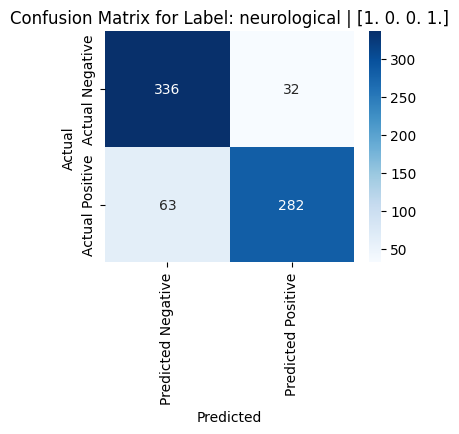

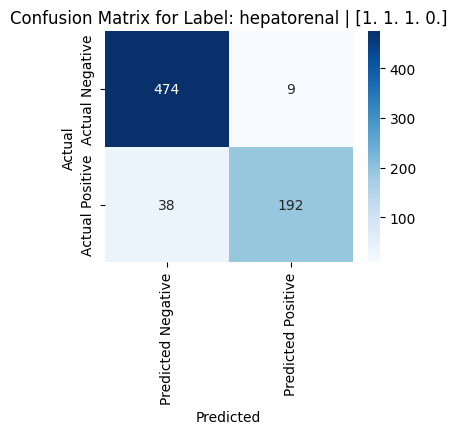

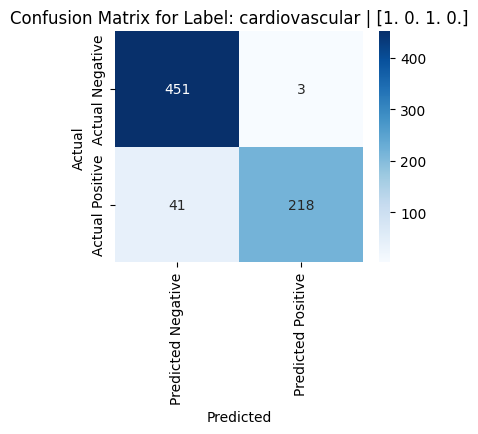

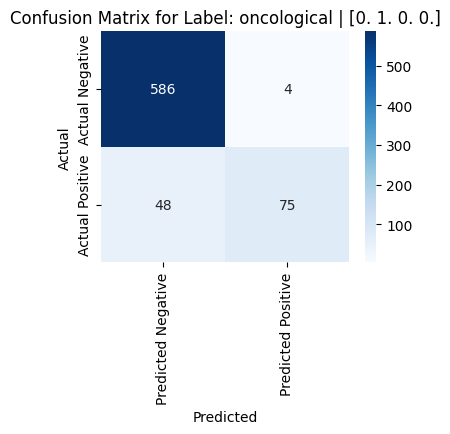

In [ ]:
# Display confusion matrix for each label
for i, cm in enumerate(conf_matrices):
    label = cm_labels[i] # Assuming labels list is accessible
    label_name = labels[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    plt.title(f'Confusion Matrix for Label: {label_name} | {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


** CALCULO DE DATA RANGES, PARA EL DASHBOARD DE LA APP **


In [25]:
# Calculate and display the range for each confusion matrix
print("Data Range for each Confusion Matrix:")
for i, cm in enumerate(conf_matrices):
    label_name = labels[i]
    min_value = np.min(cm)
    max_value = np.max(cm)
    data_range = max_value - min_value
    print(f"  {label_name}: Range = {data_range} (Min: {min_value}, Max: {max_value})")

Data Range for each Confusion Matrix:
  neurological: Range = 330 (Min: 19, Max: 349)
  hepatorenal: Range = 483 (Min: 0, Max: 483)
  cardiovascular: Range = 384 (Min: 14, Max: 398)
  oncological: Range = 590 (Min: 0, Max: 590)
